# Waterfall 

# Waterfall Sound

Installing pulse audio:    
* https://research.wmz.ninja/articles/2017/11/setting-up-wsl-with-graphics-and-audio.html    
* https://x410.dev/cookbook/wsl/enabling-sound-in-wsl-ubuntu-let-it-sing/    

Saving audio:
* https://stackoverflow.com/questions/52477889/how-to-write-pyaudio-output-into-audio-file

Layering Audio?
* http://pydub.com/
* Normalize each waveform so that when you add them the sound doesn't clip

100%|█████████████████████████████████████████████████████████████████████████████████| 845/845 [00:11<00:00, 76.62it/s]


duration: 8.1859410430839, len(frbsound)=361000


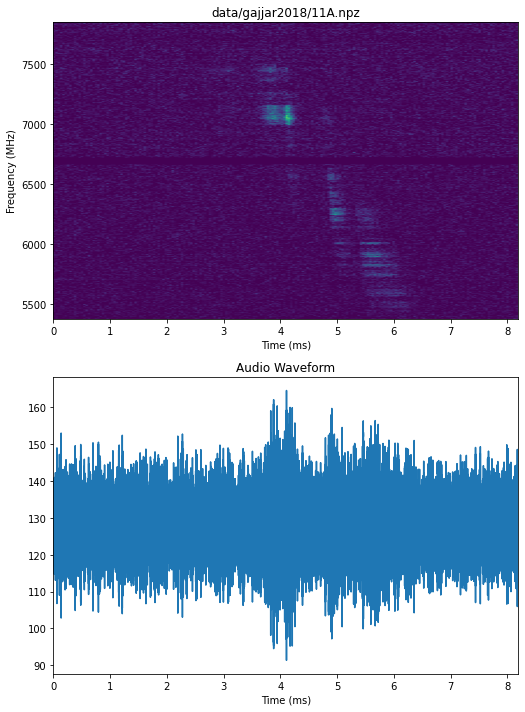

In [100]:
import driftrate, driftlaw
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from pyaudio import PyAudio
from tqdm import tqdm
import scipy.io.wavfile as wav

burstfile = 'data/gajjar2018/11A.npz'
burstnpz = np.load(burstfile, allow_pickle=True)
wfall = burstnpz['wfall'].astype(np.float64)
fres = burstnpz['bandwidth'] / wfall.shape[0]
tres = burstnpz['duration'] / wfall.shape[1]
lowest_f = min(burstnpz['dfs'])
wfall = driftrate.subtractbg(wfall, 0, 100)
wfall = driftrate.subsample(wfall, wfall.shape[0]//2, wfall.shape[1]//4)
fres *= 2; tres *= 4000
wfall = driftrate.cropwfall(wfall, twidth=100, pkidx=None)

extent, _ = driftrate.getExtents(wfall, fres, tres, lowest_freq=lowest_f)

# noise
wfall[440:460] = 0

# filter
# print(np.min(wfall), np.max(wfall), np.mean(wfall), np.median(wfall), np.std(wfall))
wfall = wfall.clip(1.3*np.mean(wfall), None)

# reset 0
wfall = wfall + abs(np.min(wfall))

# normalize
wfall = wfall/np.max(wfall)

plt.figure(figsize=(14,10))
wfallax = plt.subplot(2, 2, 1)
plt.imshow(wfall, origin='lower', aspect='auto', extent=extent)
# plt.colorbar(location='top', shrink=0.6)
plt.title(burstfile)
plt.ylabel("Frequency (MHz)")
plt.xlabel("Time (ms)")

# plt.imshow(wfall[...,87:155], origin='lower', aspect='auto', extent=extent)

## Simulated burst
# centerf = 250
# w, h = 500, 500
# x, y = np.meshgrid(range(0, w), range(0, h))
# popt = [1, w/2, centerf, 10, 80, -0.4]
# simburst = driftrate.twoD_Gaussian((y, x), *popt).reshape(h, w)
# simburst = np.flipud(simburst) / np.max(simburst)
# plt.subplot(2, 2, 2)
# plt.imshow(simburst, extent=extent, aspect='auto', origin='lower')
# # plt.colorbar(location='top', shrink=0.6)
# plt.title("Simulated")

#####################
########### FRB Sound
#####################

# Crop
# view = wfall[...,87:155] 
view = wfall
# view = simburst
extent, _ = driftrate.getExtents(view, fres, tres, lowest_freq=lowest_f)

bitrate = 44100     #number of frames per second/frameset.
totframes = int(int(extent[1]*bitrate) / view.shape[1]) * view.shape[1]
tframes = np.linspace(0, totframes, num=totframes)
times = np.linspace(extent[0], extent[1], num=totframes)
frbsound = np.zeros(totframes)
normalization = np.sqrt(view.shape[0])
# normalization = 1

pbar = enumerate(tqdm(view))
for chani, tseries in pbar:
    # time = np.interp(ti, (0, view.shape[1]), (extent[0], extent[1])) + extent[1]/view.shape[1]
    freq = np.interp(chani, (0, view.shape[0]), (extent[2], extent[3]))/2
    burstamps = tseries.repeat(int(extent[1]*bitrate) / view.shape[1])
    randomphase = np.random.uniform(0, 2*np.pi)
    waveform = burstamps * np.cos(np.pi*times*freq + randomphase) / normalization
    frbsound += waveform
    
frbsound = 128 + 127*(frbsound)
wfallax
plt.subplot(2,2,3, sharex=wfallax)
plt.plot(np.linspace(*wfallax.get_xlim(), num=len(frbsound)), frbsound); plt.title("Audio Waveform")
plt.xlabel("Time (ms)")
print(f"duration: {len(frbsound)/bitrate}, {len(frbsound)=}")
plt.tight_layout()

In [101]:
# if frequency > bitrate:
#     bitrate = frequency+100
bitrate = 44100     #number of frames per second/frameset.
p = PyAudio()
try:
    stream = p.open(format=p.get_format_from_width(1), channels=1, rate=bitrate, output=True)
    stream.write(frbsound.astype(np.byte))
    stream.stop_stream()
    stream.close()
    p.terminate()
except OSError:
    print("Audio device down.")

wav.write('sound/frb11A.wav', bitrate, frbsound.astype(np.byte)); print("Saved audio file.")

Audio device down.
Saved audio file.


## Inverse Short Time Fourier Transform (ISTFT)

167956


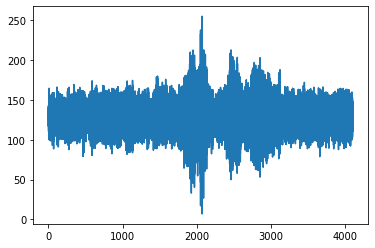

In [5]:

import math
import numpy as np
from pyaudio import PyAudio
from tqdm import tqdm
import scipy.io.wavfile as wav
from scipy.signal import istft, stft, check_COLA, check_NOLA, savgol_filter

burst = wfall

# print(check_COLA(wfall), check_NOLA(wfall))
t, frbsound = istft(burst, fs=tres*1000)
# frbsound = savgol_filter(frbsound, 7, 6)
print(len(frbsound))
frbsound = 128 + 127*(frbsound / np.max(frbsound))
plt.plot(t, frbsound); plt.title("Inverse Short Time Fourier Transform")

# Waterfall Image

/tmp/ipykernel_142/1456146033.py:79: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d", proj_type="ortho")


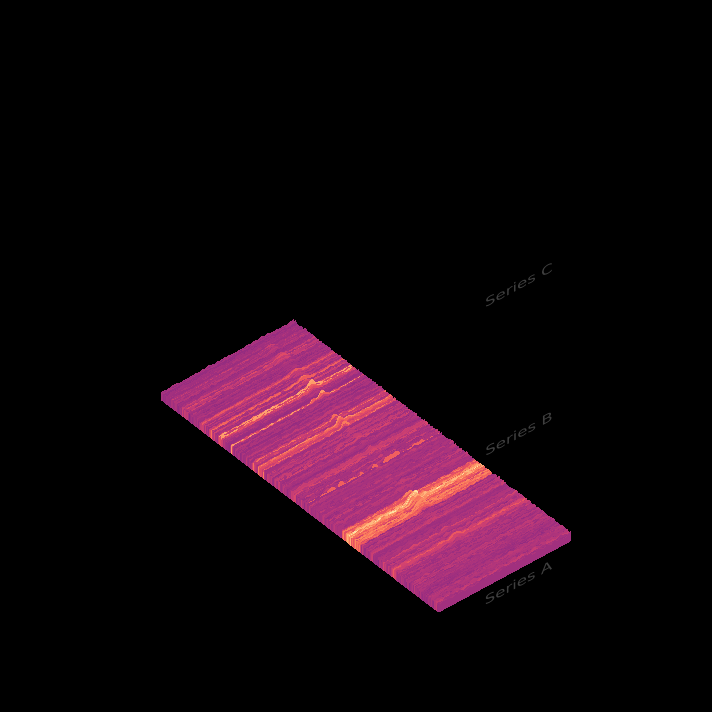

In [70]:
# ----------------------------------------------------------------------------
# Title:   Scientific Visualisation - Python & Matplotlib
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon
from scipy.ndimage import gaussian_filter1d
from matplotlib.collections import PolyCollection
from matplotlib.transforms import Affine2D
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.font_manager import FontProperties


def text3d(ax, xyz, s, zdir="z", size=0.1, angle=0, **kwargs):
    x, y, z = xyz
    if zdir == "y":
        xy, z = (x, z), y
    elif zdir == "x":
        xy, z = (y, z), x
    else:
        xy, z = (x, y), z
    path = TextPath((0, 0), s, size=size, prop=FontProperties(family="Roboto"))
    V = path.vertices
    V[:, 0] -= (V[:, 0].max() - V[:, 0].min()) / 2
    trans = Affine2D().rotate(angle).translate(xy[0], xy[1])
    path = PathPatch(trans.transform_path(path), **kwargs)
    ax.add_patch(path)
    art3d.pathpatch_2d_to_3d(path, z=z, zdir=zdir)


# Some nice but random curves
def random_curve(n=100):
    Y = np.random.uniform(0, 1, n)
    Y = gaussian_filter1d(Y, 1)
    X = np.linspace(-1, 1, len(Y))
    Y *= np.exp(-2 * (X * X))
    return Y


def cmap_plot(Y, ymin=0, ymax=1, n=50, cmap="magma", y0=0):
    X = np.linspace(0.3, 0.7, len(Y))
    Y = gaussian_filter1d(Y, 2)

    verts = []
    colors = []
    P = Polygon([(X[0], 0), *zip(X, Y), (X[-1], 0)])

    dy = (ymax - ymin) / n
    cmap = plt.cm.get_cmap(cmap)
    cnorm = matplotlib.colors.Normalize(vmin=ymin, vmax=ymax)

    for y in np.arange(Y.min(), Y.max(), dy):
        B = box(0, y, 10, y + dy)
        # I = P.intersection(B)
        I = P
        if hasattr(I, "geoms"):
            for p in I.geoms:
                V = np.array(p.exterior.coords)
                V[:, 1] += y0
                verts.append(V)
                colors.append(cmap(cnorm(y)))
        else:
            if I.exterior.coords:
                V = np.array(I.exterior.coords)
                V[:, 1] += y0
                verts.append(V)
                colors.append(cmap(cnorm(y)))

    return verts, colors


fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor("black")
ax = fig.gca(projection="3d", proj_type="ortho")
ax.patch.set_facecolor("black")

# Make panes transparent
ax.xaxis.pane.fill = False  # Left pane
ax.yaxis.pane.fill = False  # Right pane
ax.zaxis.pane.fill = False  # Right pane

# Remove grid lines
ax.grid(False)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Transparent spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# No ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])



numpoints = wfall.shape[0]
verts = []
for spec in wfall:
    ts = range(0, len(spec))
    v
# for zs, spectra in zip(np.range(0, wfall.shape, wfall.shape[0]), wfall):
#     collection = PolyCollection(
#         verts, antialiased=False, edgecolors="None", facecolor=colors
#     )
#     ax.add_collection3d(collection, zdir="x", zs=zs)

#     Y = 0.1 * random_curve()
#     verts, colors = cmap_plot(Y, ymin=0, ymax=0.075, n=50, cmap="magma", y0=0.4)
#     collection = PolyCollection(
#         verts, antialiased=False, edgecolors="None", facecolor=colors
#     )
#     ax.add_collection3d(collection, zdir="x", zs=zs)

#     Y = 0.1 * random_curve()
#     verts, colors = cmap_plot(Y, ymin=0, ymax=0.075, n=50, cmap="magma", y0=1.0)
#     collection = PolyCollection(
#         verts, antialiased=False, edgecolors="None", facecolor=colors
#     )
#     ax.add_collection3d(collection, zdir="x", zs=zs)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.view_init(elev=40, azim=-40)
plt.tight_layout()
# plt.savefig("graphics/waterfall-3d.pdf")
# plt.savefig("./waterfall-3d.png", dpi=300)
plt.show()